# Preprocessing and clustering 3k PBMCs

In [1]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/smcheong/.conda/envs/scanpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.8.1 pandas==1.4.3 scikit-learn==1.1.1 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names = 'gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache = True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


Return type of `sc.read_10x_mtx()` is anndata (annotated data matrix).

https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData

In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


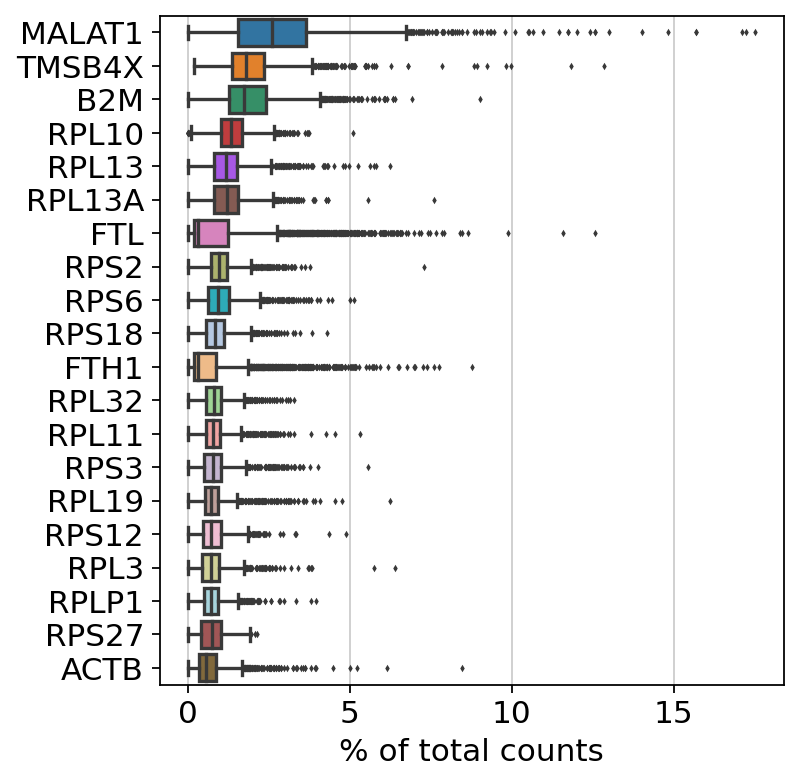

In [8]:
# genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top = 20, )

Plotting: `pl`

https://scanpy.readthedocs.io/en/stable/api.html#module-scanpy.pl

In [9]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)  # only keep cells w/ at least 200 genes expressed

In [10]:
sc.pp.filter_genes(adata, min_cells=3)  # only keep genes that are expressed in at least 3 cells

filtered out 19024 genes that are detected in less than 3 cells


Preprocessing: `pp`

https://scanpy.readthedocs.io/en/stable/api.html

Let’s assemble some information about mitochondrial genes.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') # annotate the group of mitochondiral genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var_names -> `Index` -> pandas.Index

pandas.Index.str
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Index.str.html

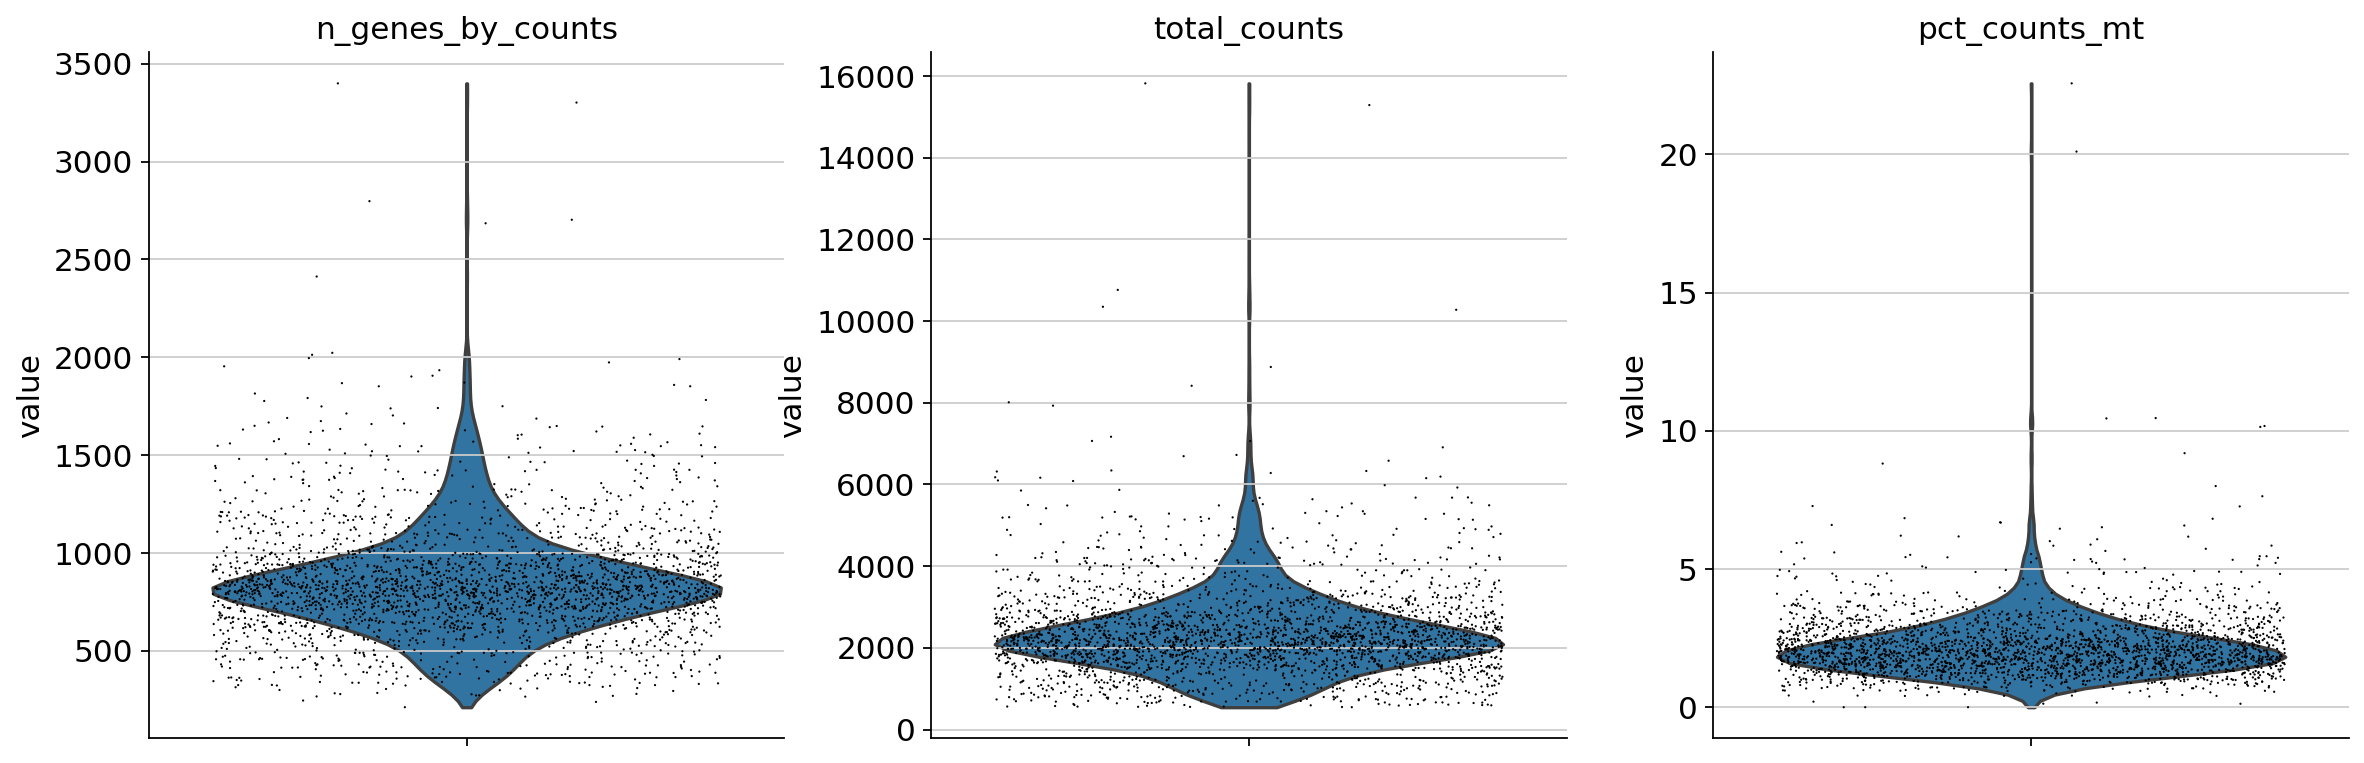

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

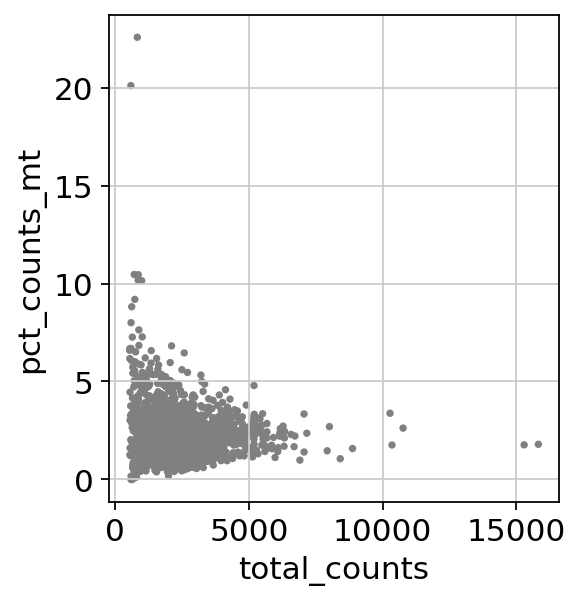

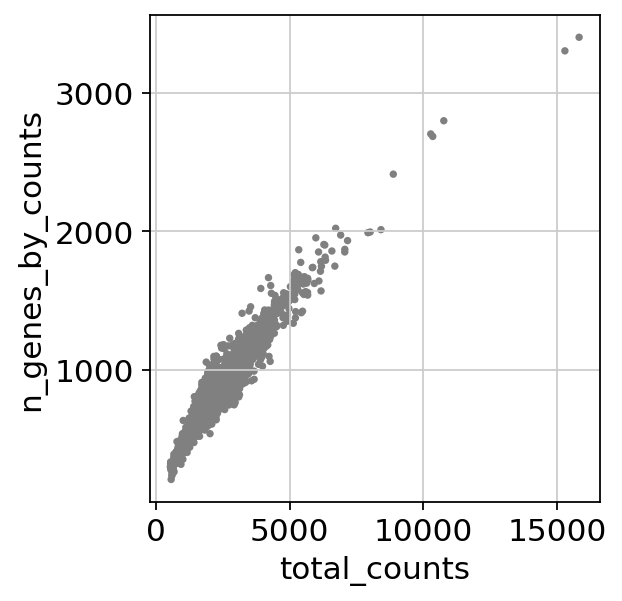

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

pct_counts_mt: Proportion of total counts for a cell which are mitochondrial.

Actually do the filtering by slicing the AnnData object.

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/smcheong/.conda/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [16]:
sc.pp.log1p(adata)

Identify highly-variable genes.

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


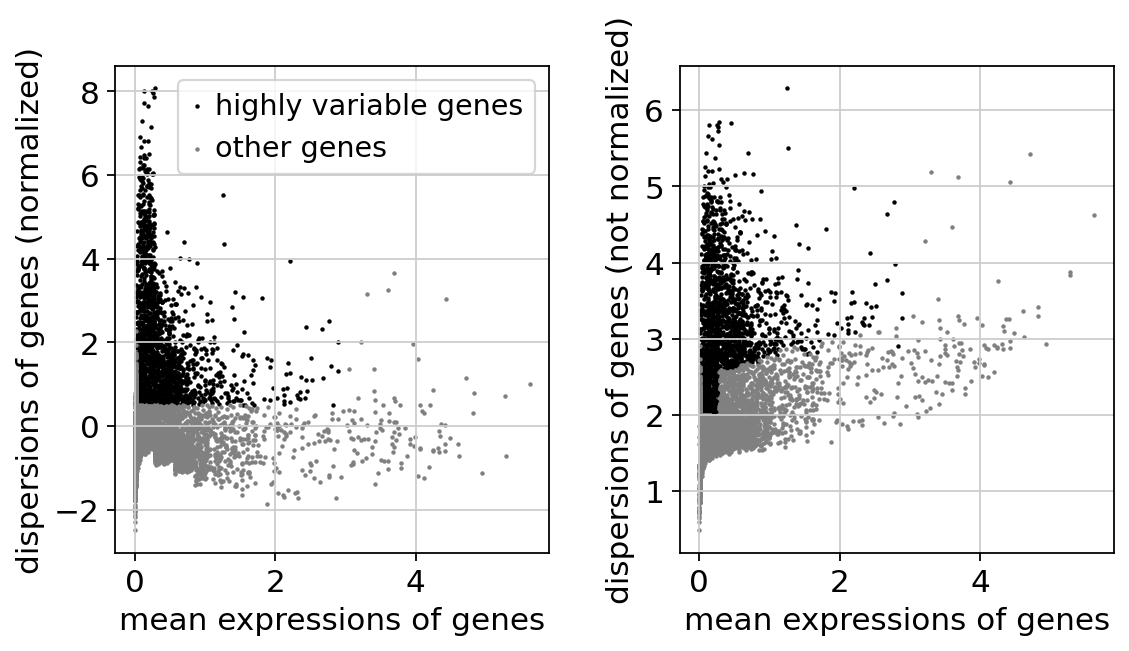

In [18]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

In [19]:
adata.raw = adata

Actually do the filtering

In [20]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [22]:
sc.pp.scale(adata, max_value=10)

### 비교

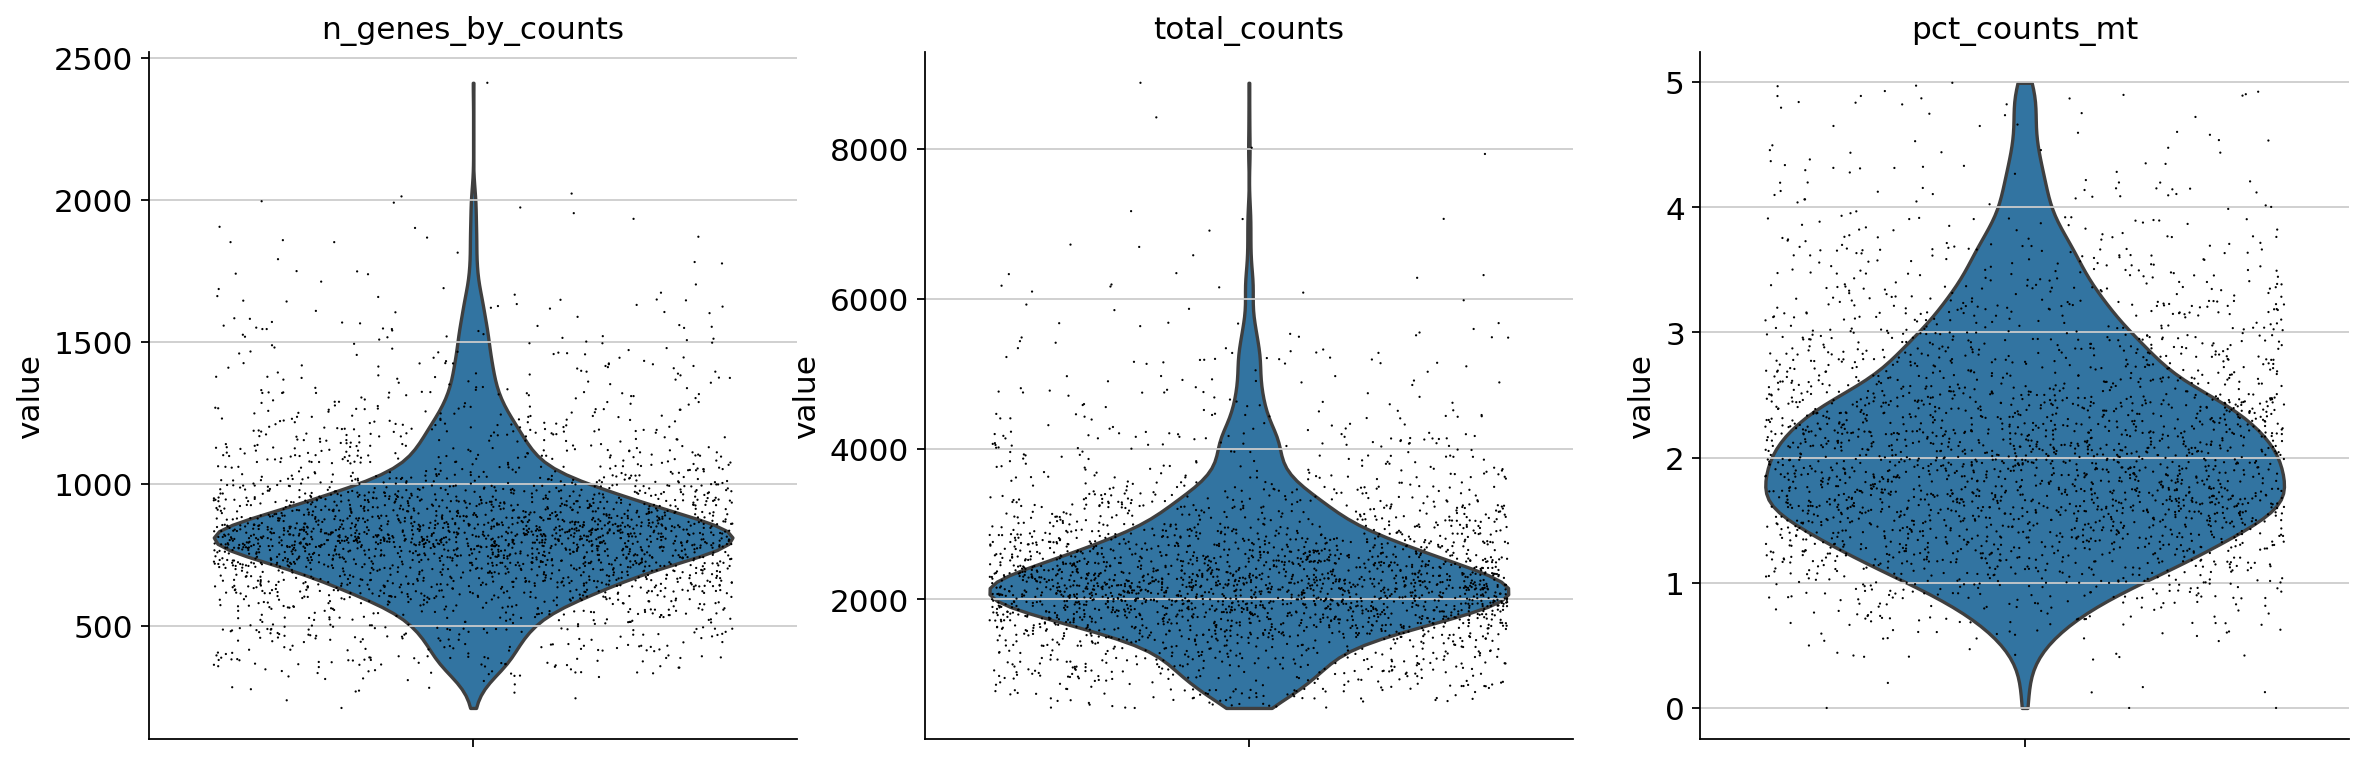

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

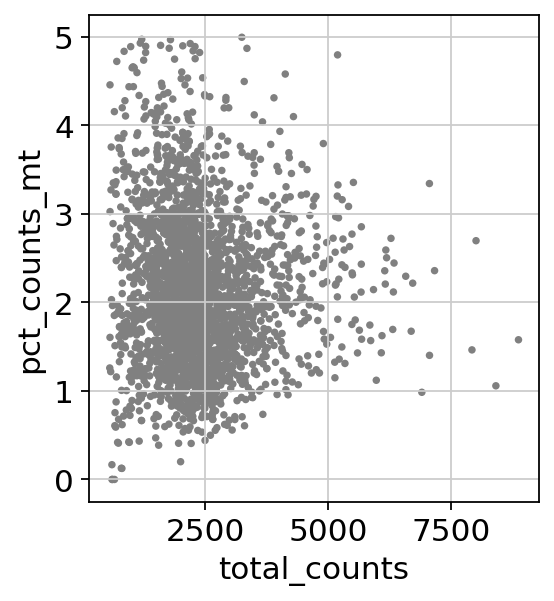

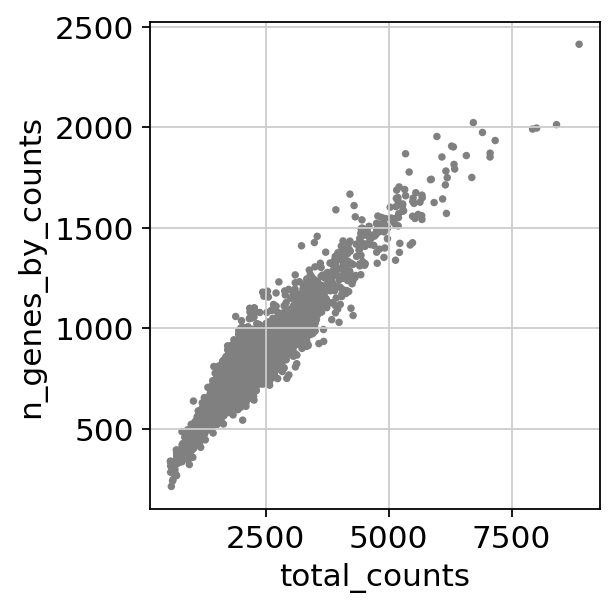

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

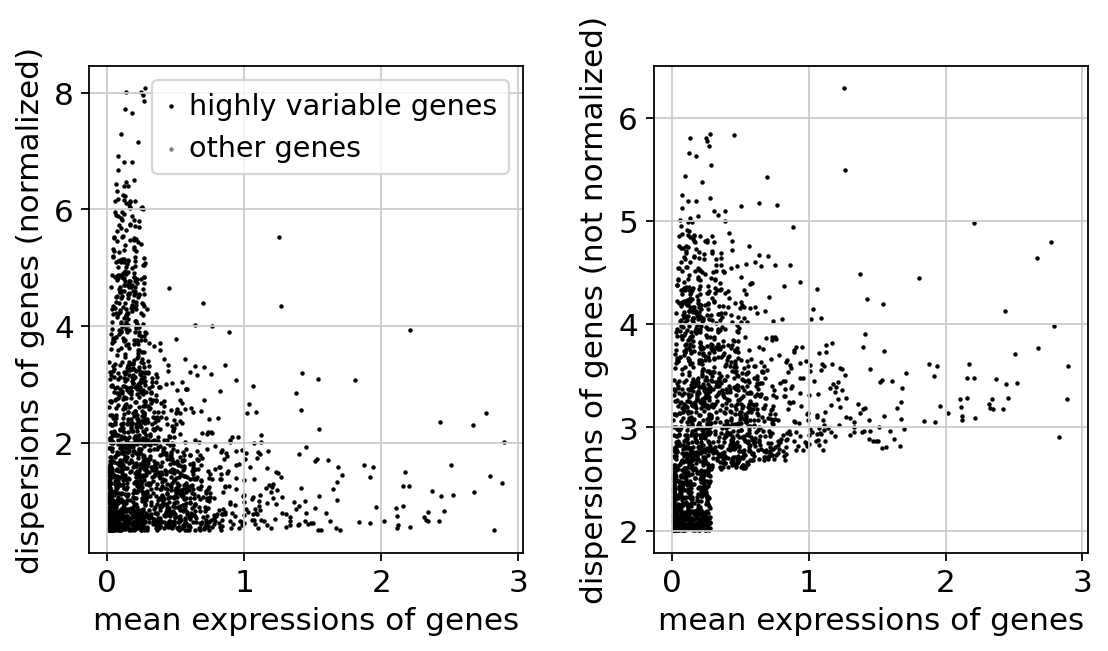

In [25]:
sc.pl.highly_variable_genes(adata)

## PCA

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


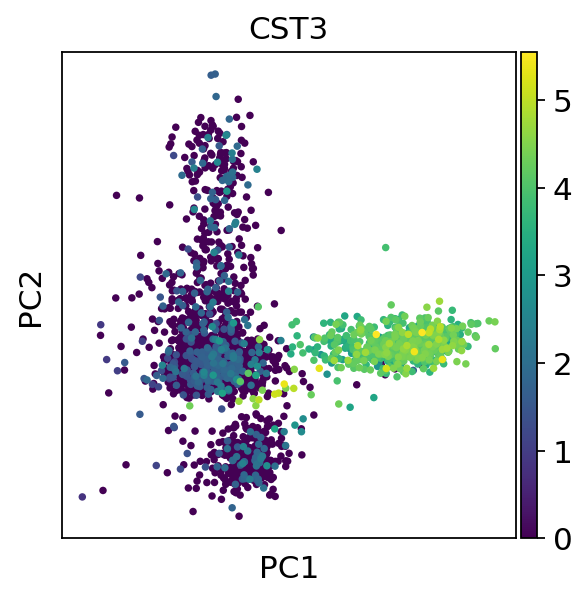

In [27]:
sc.pl.pca(adata, color='CST3')

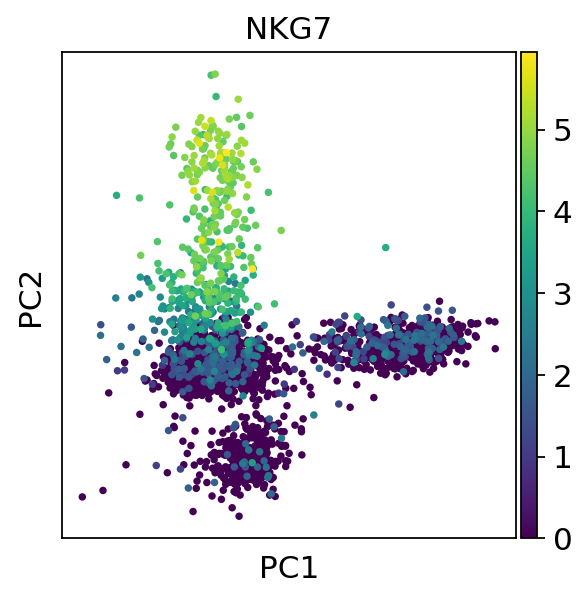

In [28]:
# just curious
sc.pl.pca(adata, color='NKG7')

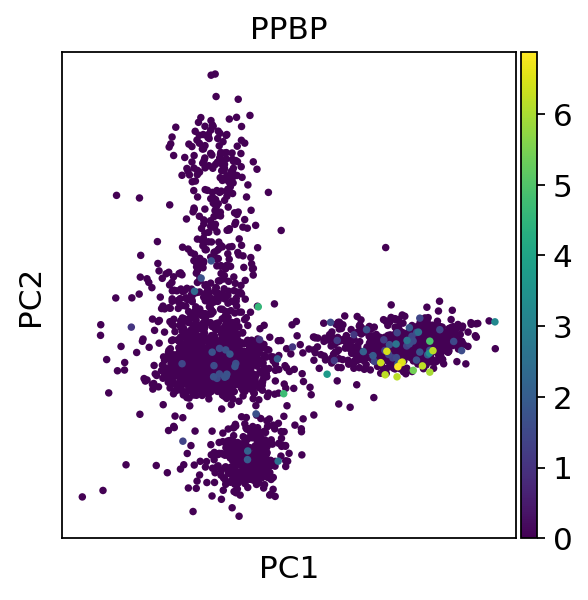

In [29]:
# just curious
sc.pl.pca(adata, color='PPBP')

Tools: `tl`

a *tool* usually adds an easily interpretable annotation to the data matrix, which can then be visualized with a corresponding plotting function.

In our experience, often a rough estimate of the number of PCs does fine.

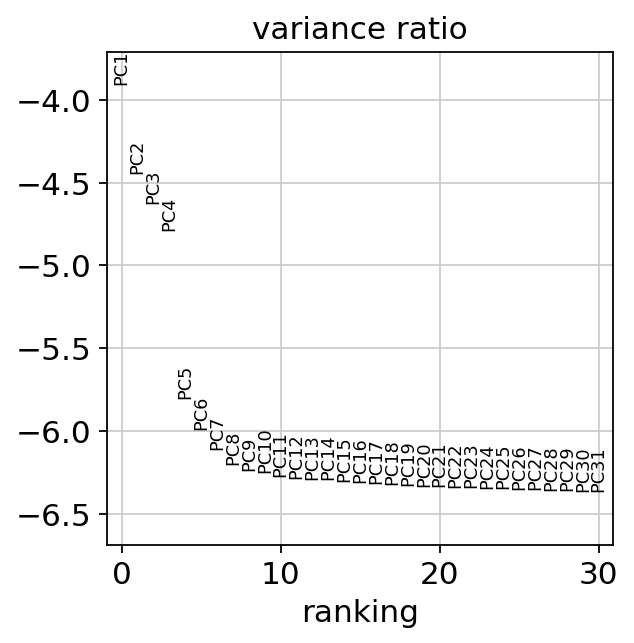

In [30]:
sc.pl.pca_variance_ratio(adata, log=True)

In [31]:
# Save the result
adata.write(results_file)

`adata.write`: Write `.h5ad`-formatted hdf5 file.

In [32]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [33]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


`pp.neighbors`: Compute a neighborhood graph of observations

The neighbor search efficiency of this heavily relies on UMAP

## Embedding the neighborhood graph

In [34]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


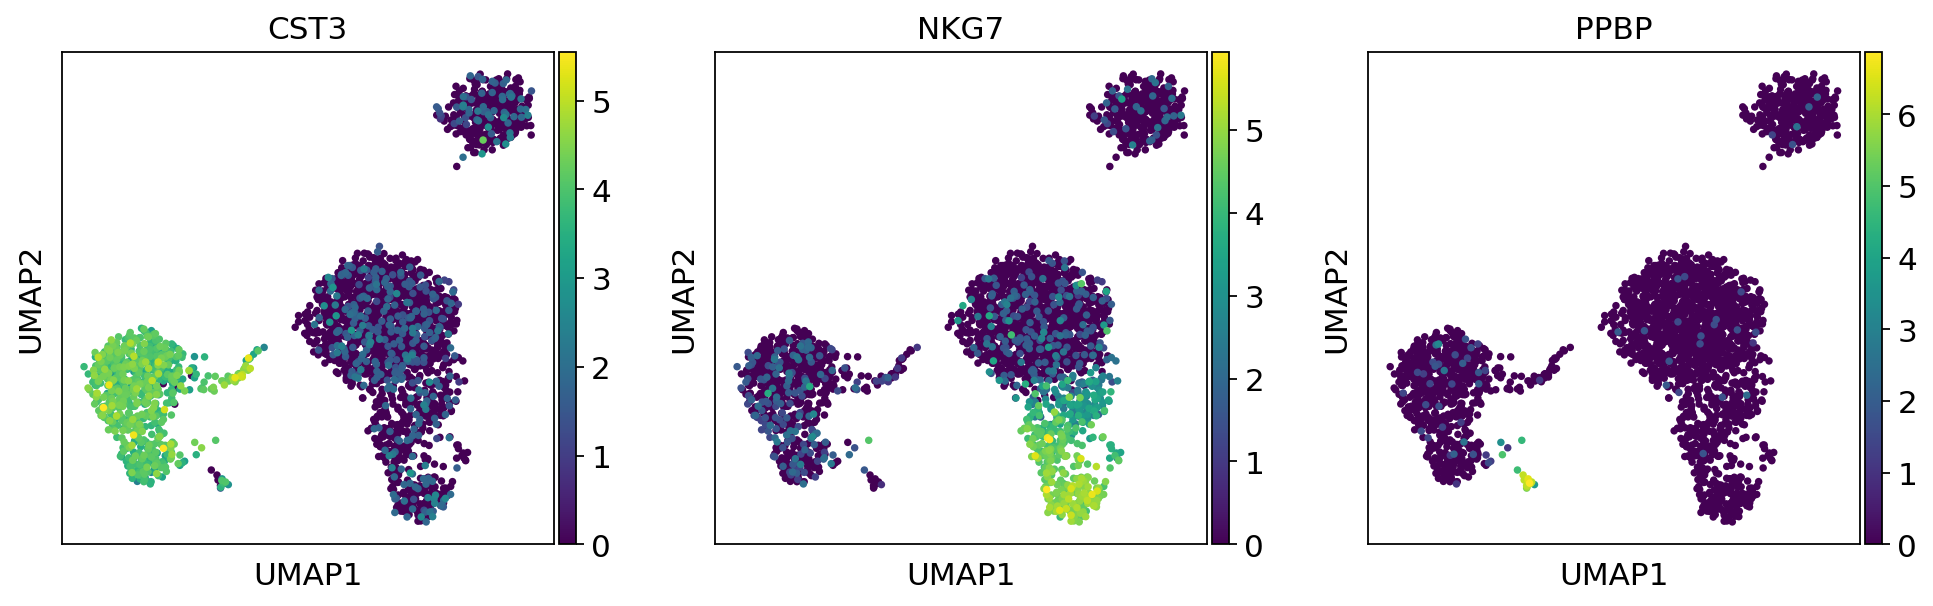

In [35]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the .raw attribute of adata, the previous plots showed the “raw” (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don’t want to use .raw.

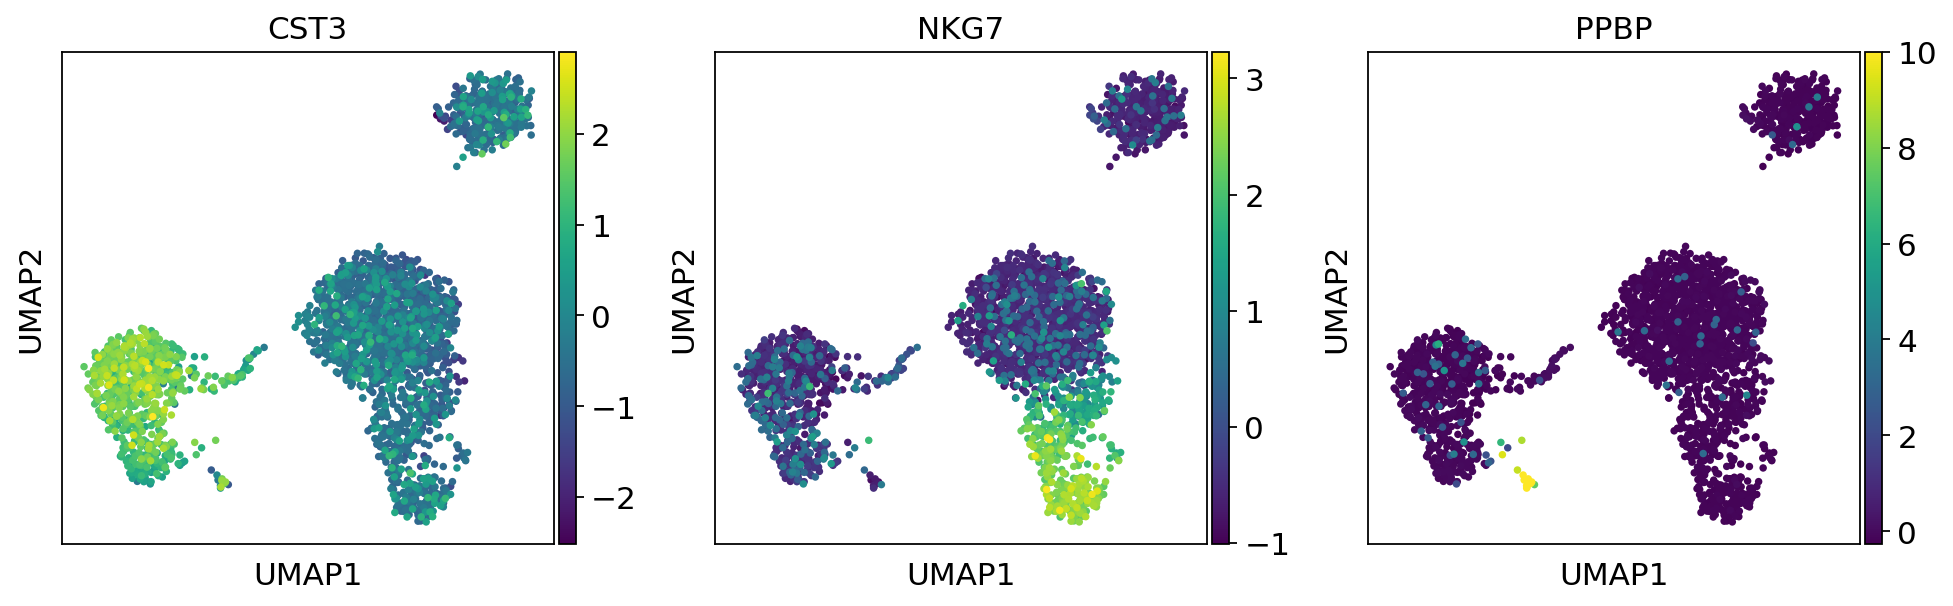

In [36]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the nieghborhood graph

In [37]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


`scanpy.tl.leiden`: Cluster cells into subgroups (using the Leiden algorithm)

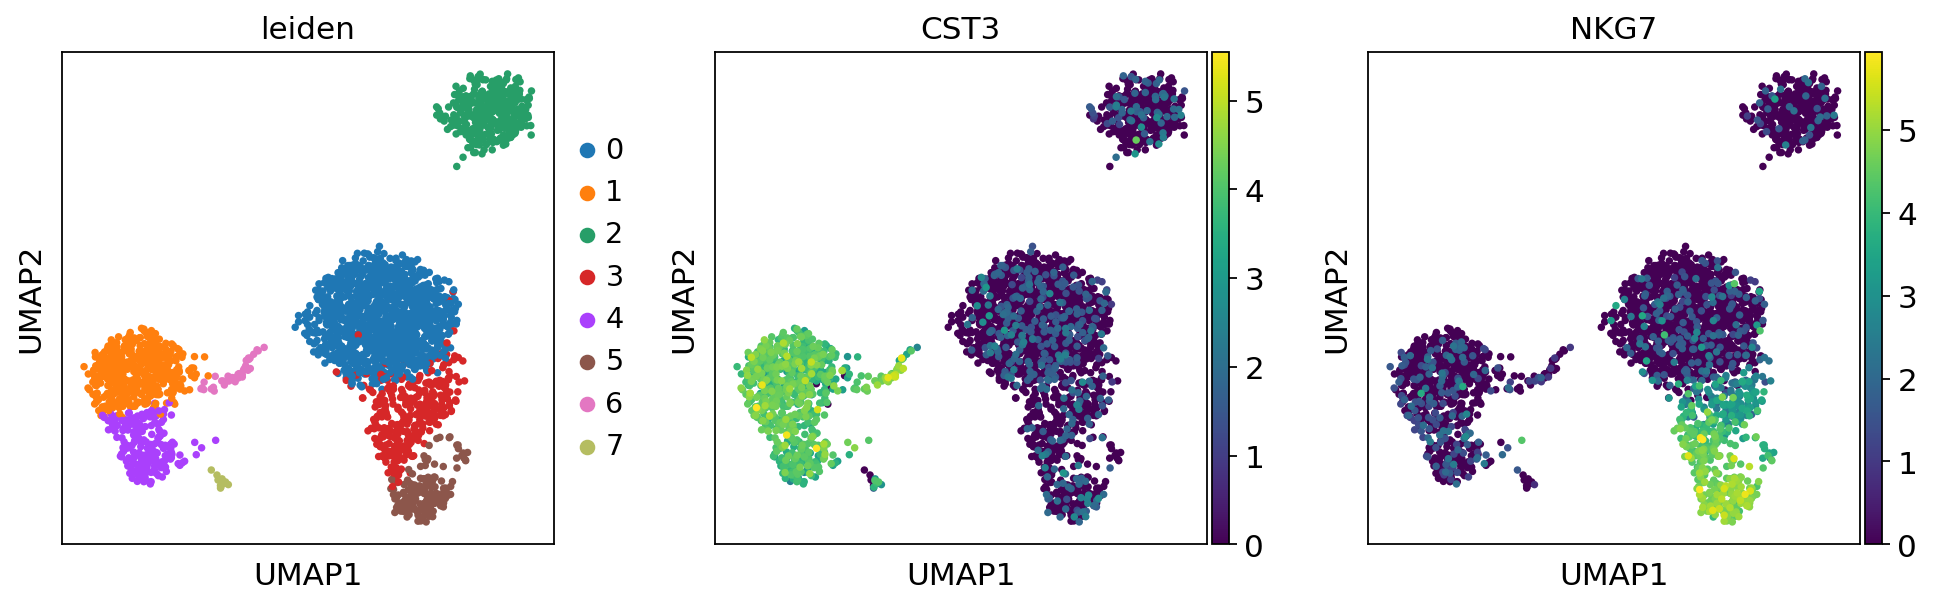

In [38]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [39]:
adata.write(results_file)

## Finding marker genes

compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


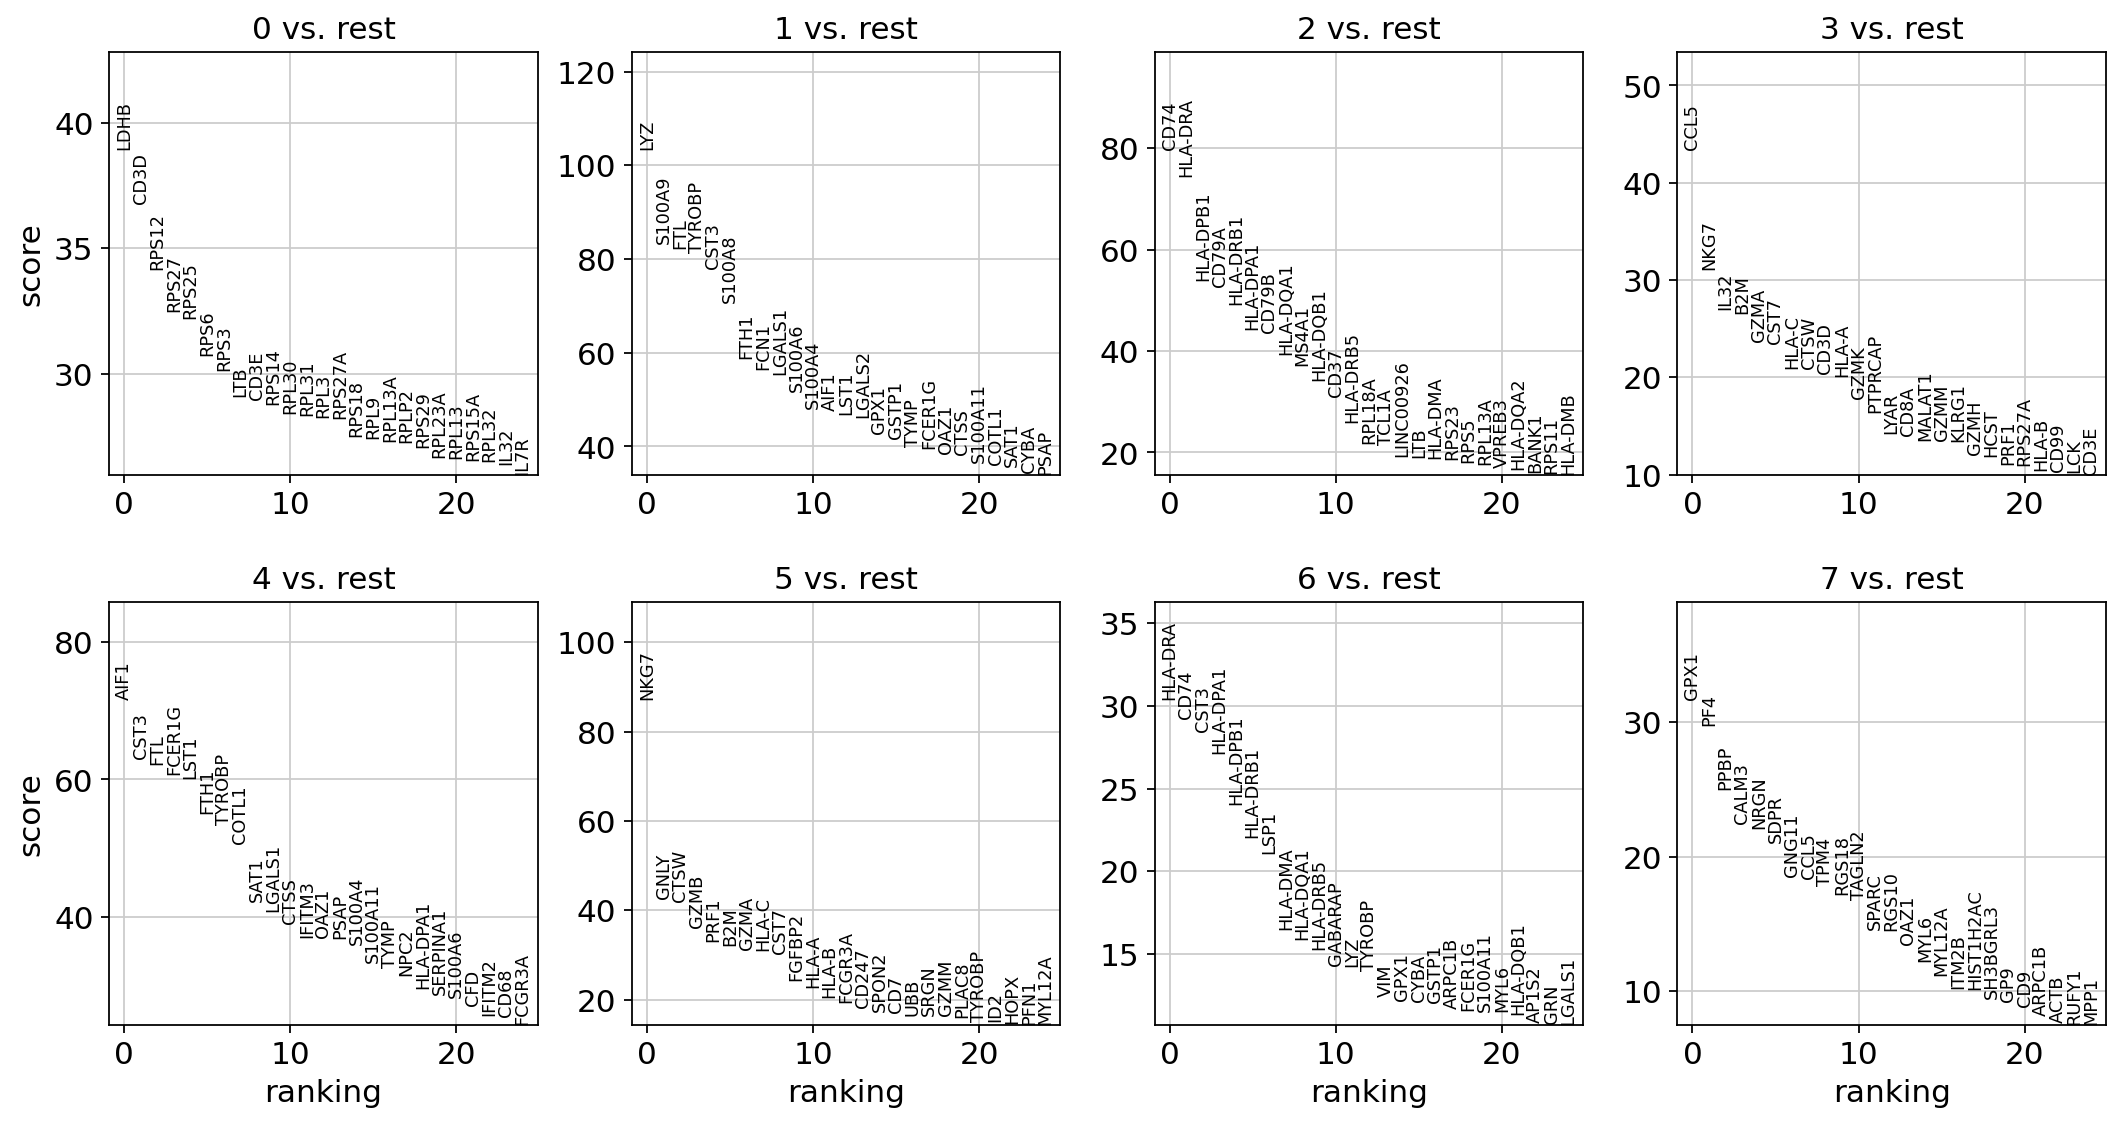

In [40]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

scanpy.tl.rank_genes_groups: Rank genes for characterizing groups.

In [41]:
sc.settings.verbosity = 2 # reduce the verbosity

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. : publication에 추천

much more powerful differential testing packages: MAST, limma, DESeq2, diffxpy

ranking genes
    finished (0:00:01)


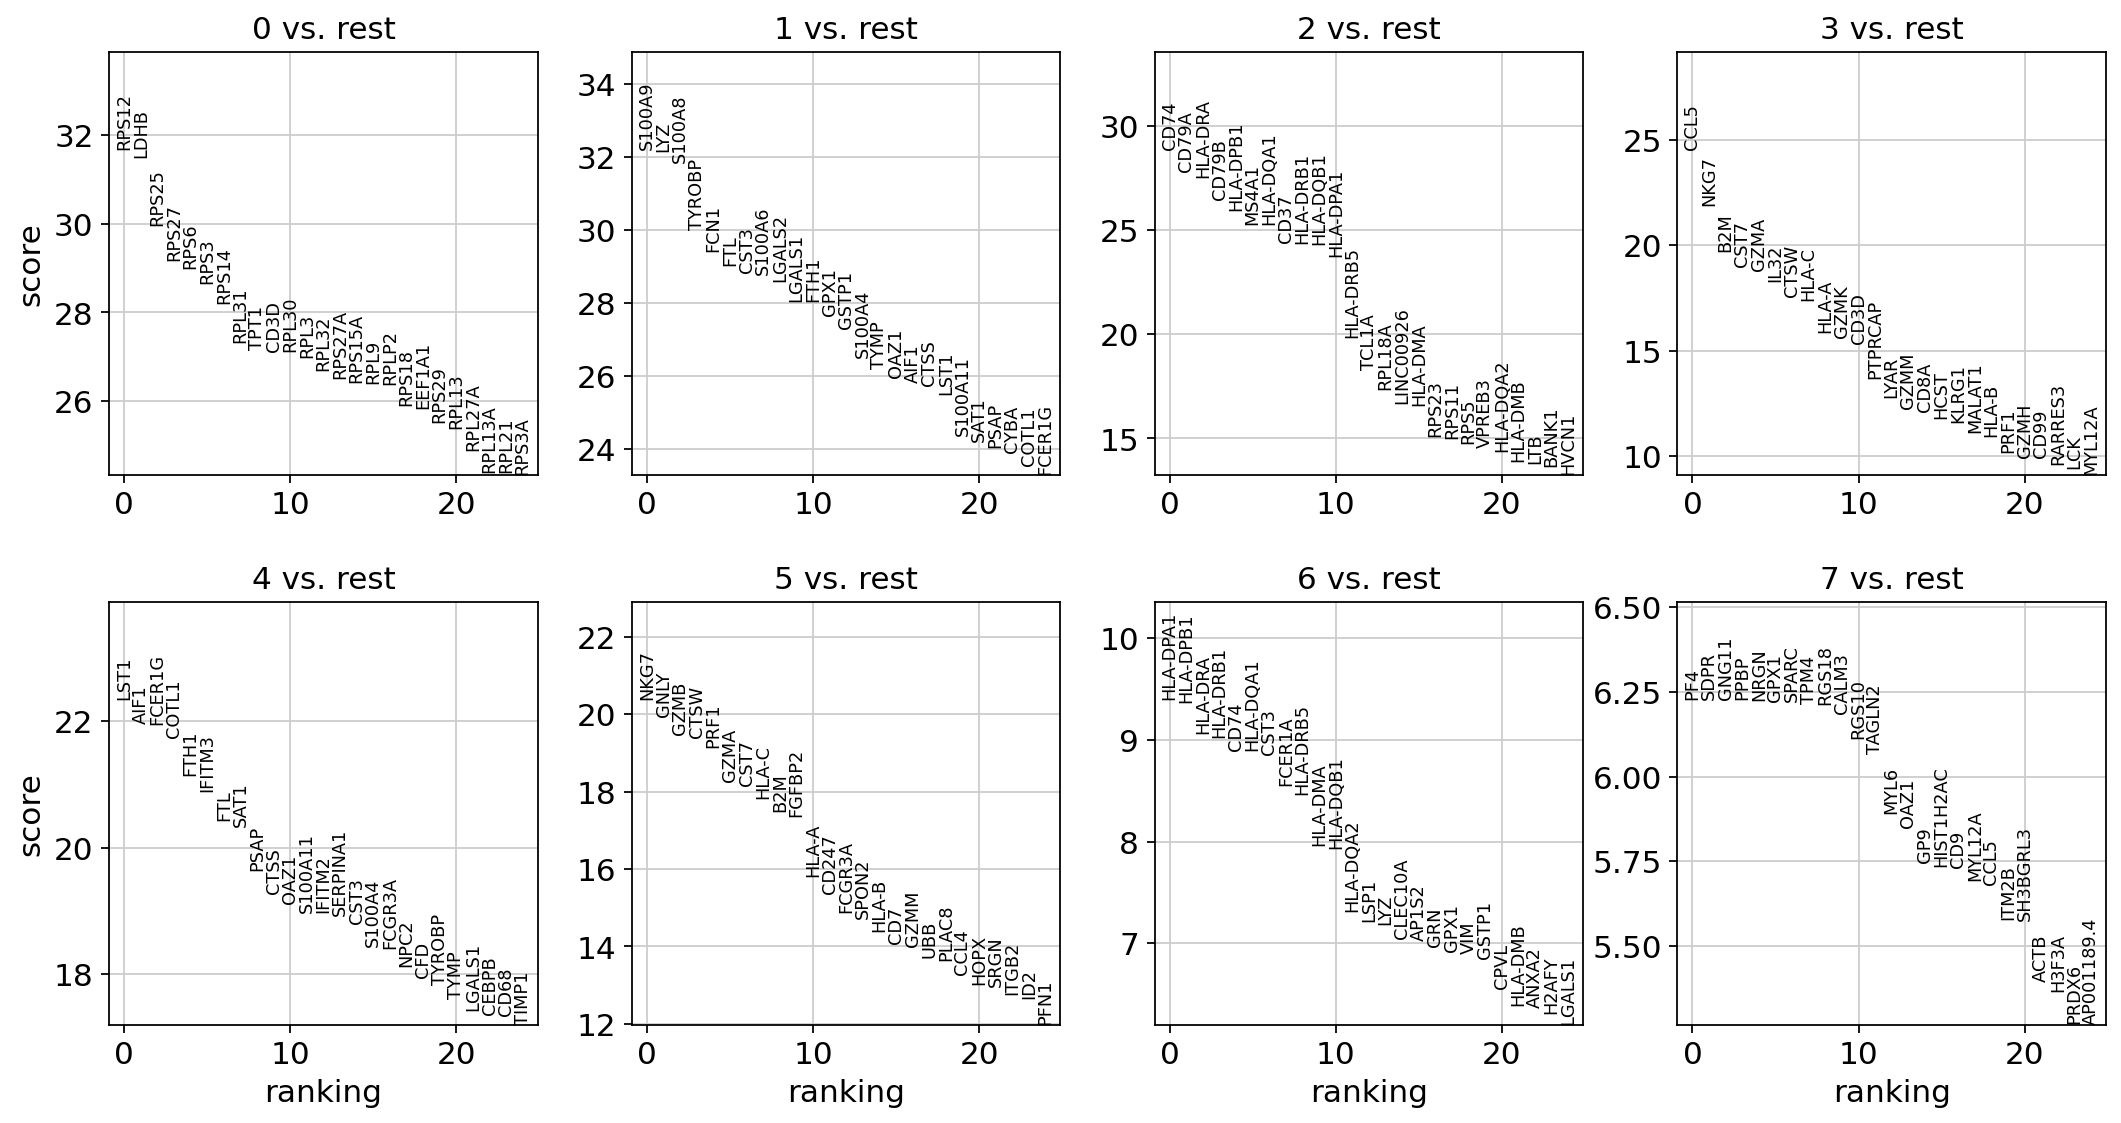

In [42]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [43]:
# Save the result.
adata.write(results_file)

As an alternative, let us rank genes using logistic regression.
We use a multi-variate appraoch.

In [53]:
# logistir regression이 안 되어서 임의로 추가함
sc.pp.log1p(adata)

/home/smcheong/.conda/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


ranking genes
    finished (0:00:05)


/home/smcheong/.conda/envs/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


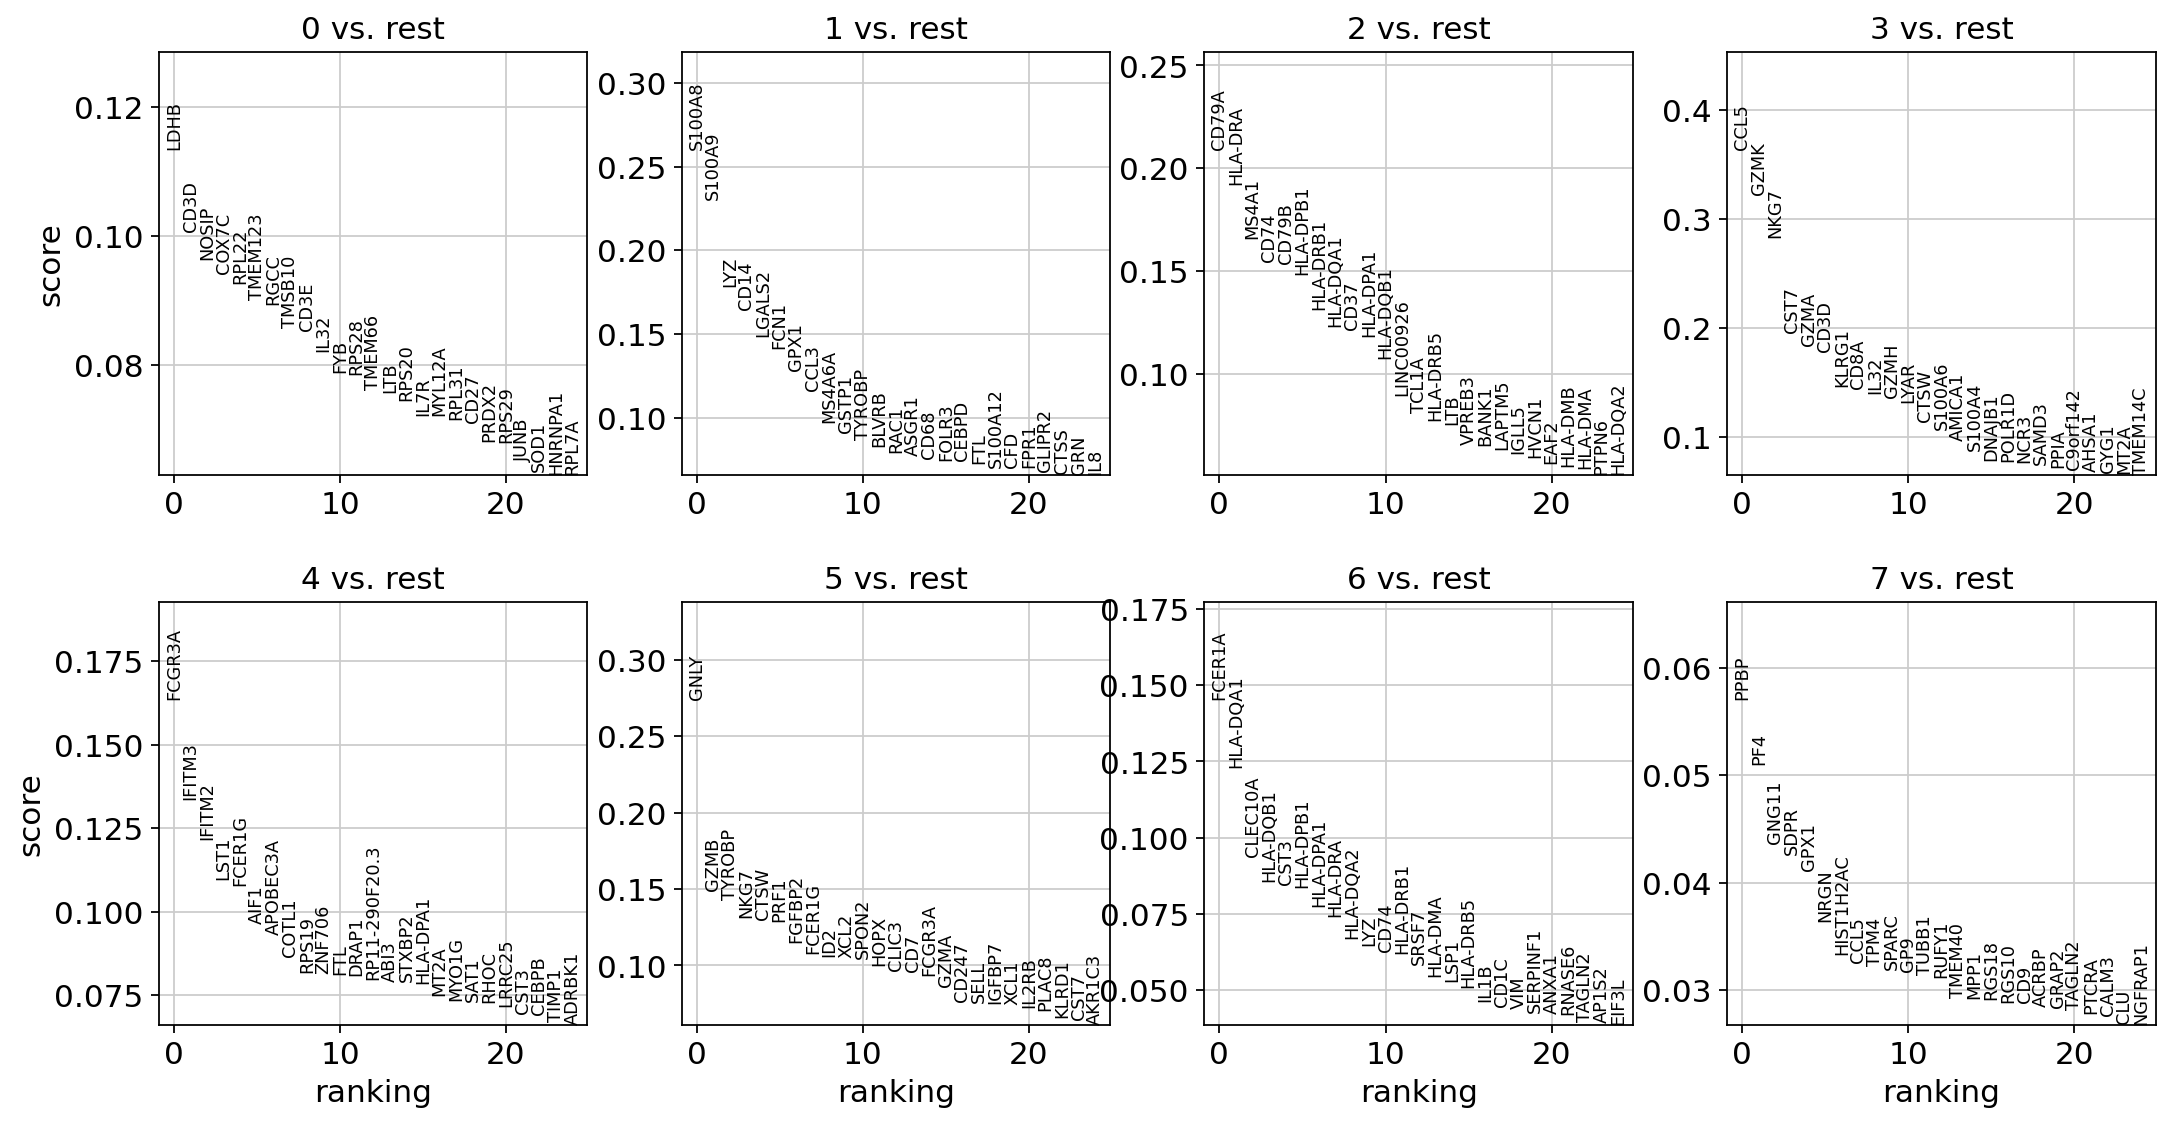

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [46]:
adata = sc.read(results_file)

In [47]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3       4     5         6      7
0  RPS12  S100A9      CD74  CCL5    LST1  NKG7  HLA-DPA1    PF4
1   LDHB     LYZ     CD79A  NKG7    AIF1  GNLY  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  FCER1G  GZMB   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7   COTL1  CTSW  HLA-DRB1   PPBP
4   RPS6    FCN1  HLA-DPB1  GZMA    FTH1  PRF1      CD74   NRGN

Get a table with the scores and groups.

In [48]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  3.436341e-220  S100A9  1.842655e-227      CD74  2.487145e-183  CCL5   
1   LDHB  1.030869e-217     LYZ  8.413552e-227     CD79A  1.679730e-170  NKG7   
2  RPS25  2.383694e-197  S100A8  1.257243e-222   HLA-DRA  6.942399e-167   B2M   
3  RPS27  3.494343e-187  TYROBP  6.067012e-198     CD79B  2.569135e-154  CST7   
4   RPS6  9.208450e-185    FCN1  4.894805e-190  HLA-DPB1  3.580735e-148  GZMA   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  3.955974e-133    LST1  1.419732e-110  NKG7  1.923512e-92  HLA-DPA1   
1  2.578550e-106    AIF1  7.130846e-107  GNLY  1.513503e-88  HLA-DPB1   
2   2.100818e-86  FCER1G  1.045064e-106  GZMB  1.405777e-84   HLA-DRA   
3   2.637186e-80   COTL1  9.908055e-105  CTSW  7.510027e-84  HLA-DRB1   
4   4.991254e-79    FTH1   3.935567e-99  PRF1  1.053180e-81      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

Compare to a **single** cluster:

ranking genes
    finished (0:00:00)


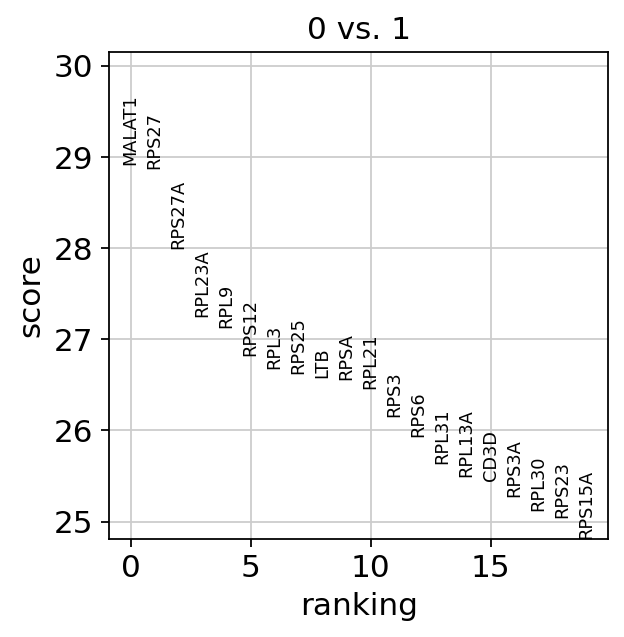

In [54]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use sc.pl.rank_genes_groups_violin.

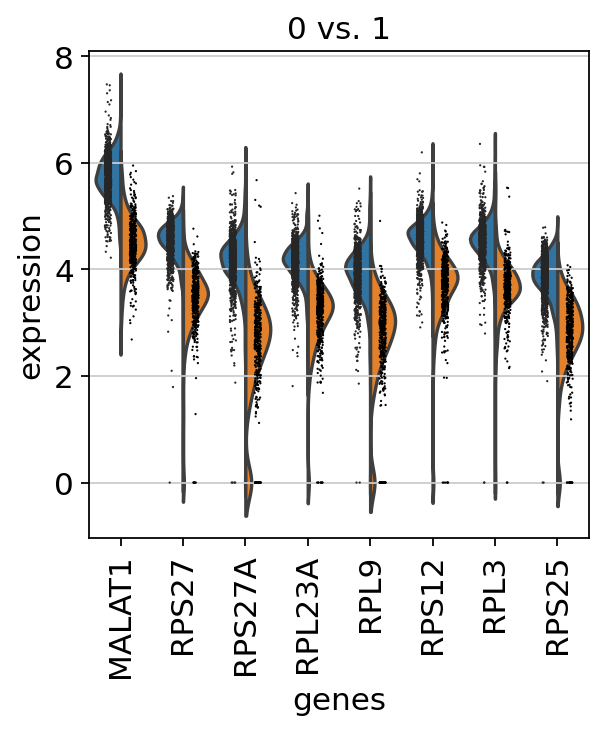

In [57]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the **rest** of the groups):

In [60]:
adata = sc.read(results_file)

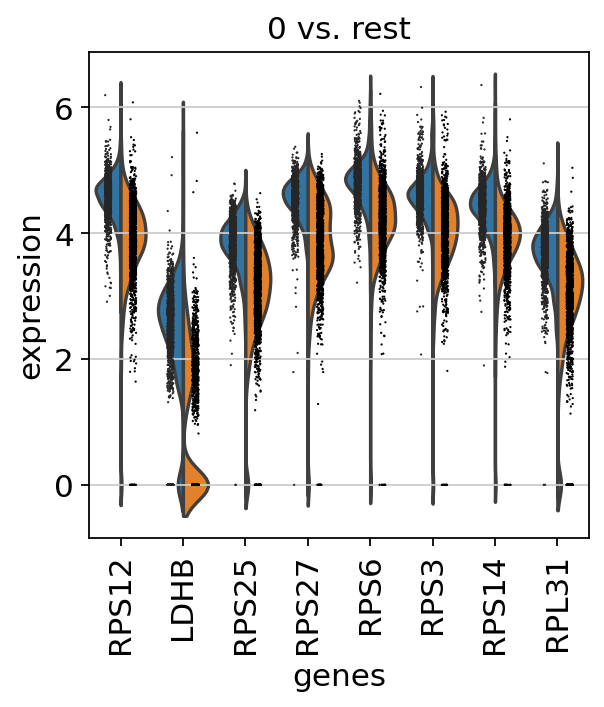

In [61]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene **across groups**, use the following.

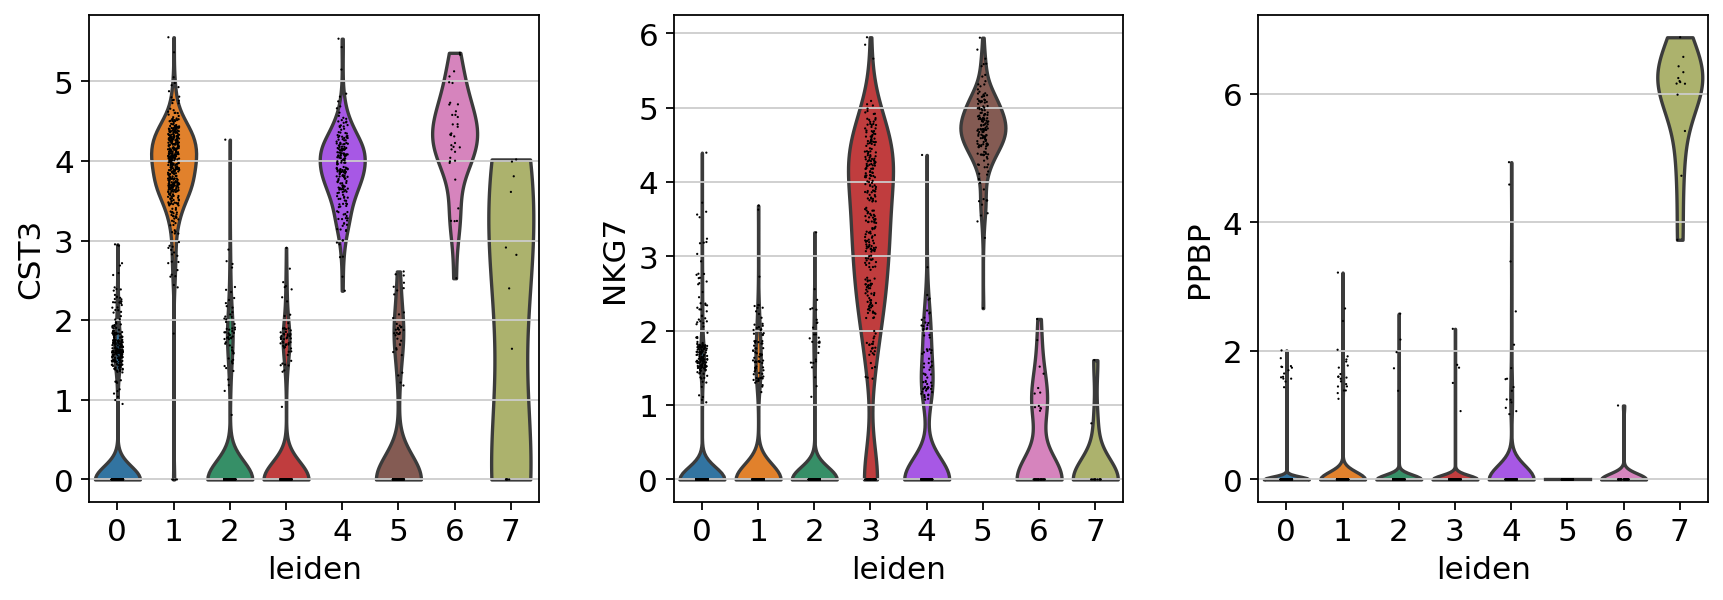

In [63]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [70]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'FCGR3A Monocytes', 'NK',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

/home/smcheong/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


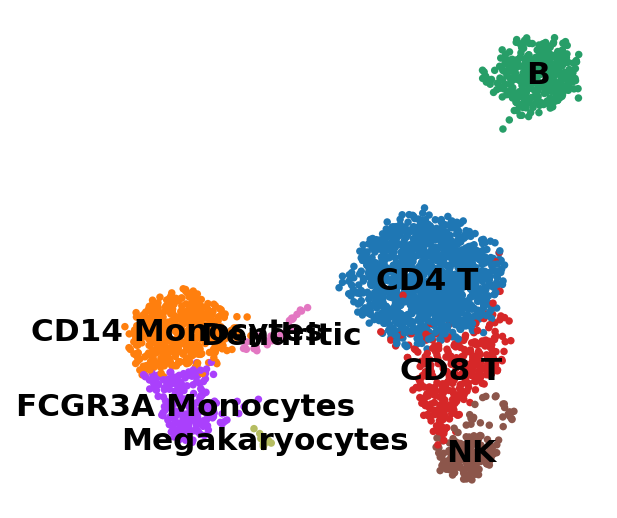

In [71]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

#### Marker를 보고 cell type 지정을 한 것인지?

Now that we annotated the cell types, let us visualize the marker genes.



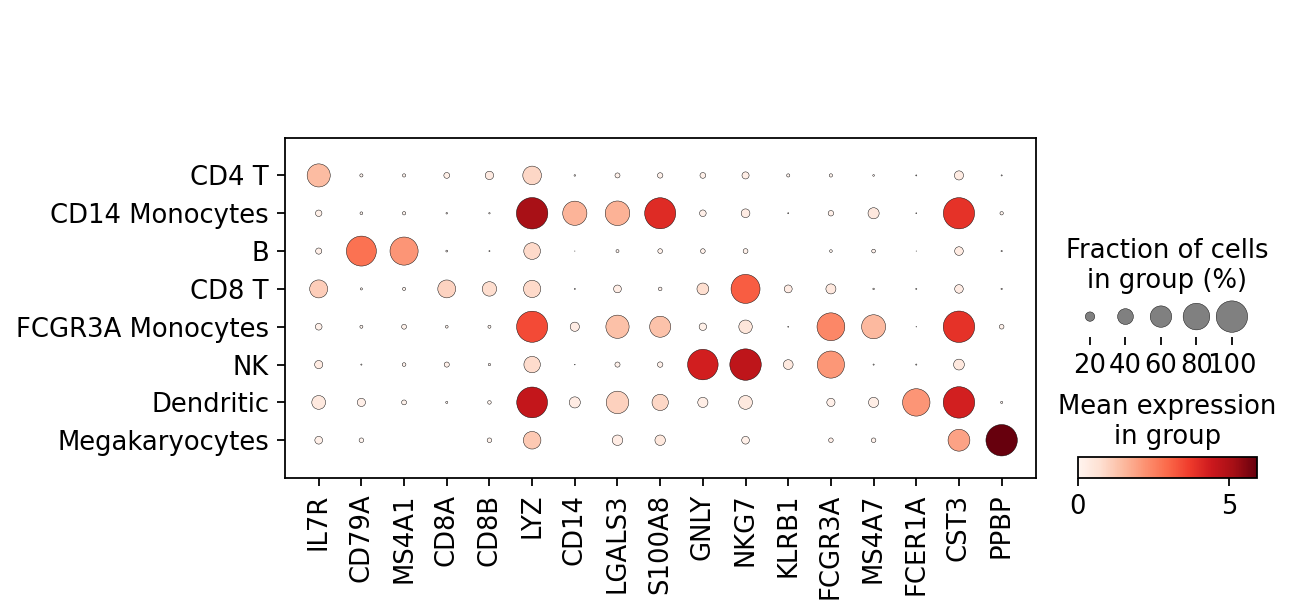

In [72]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

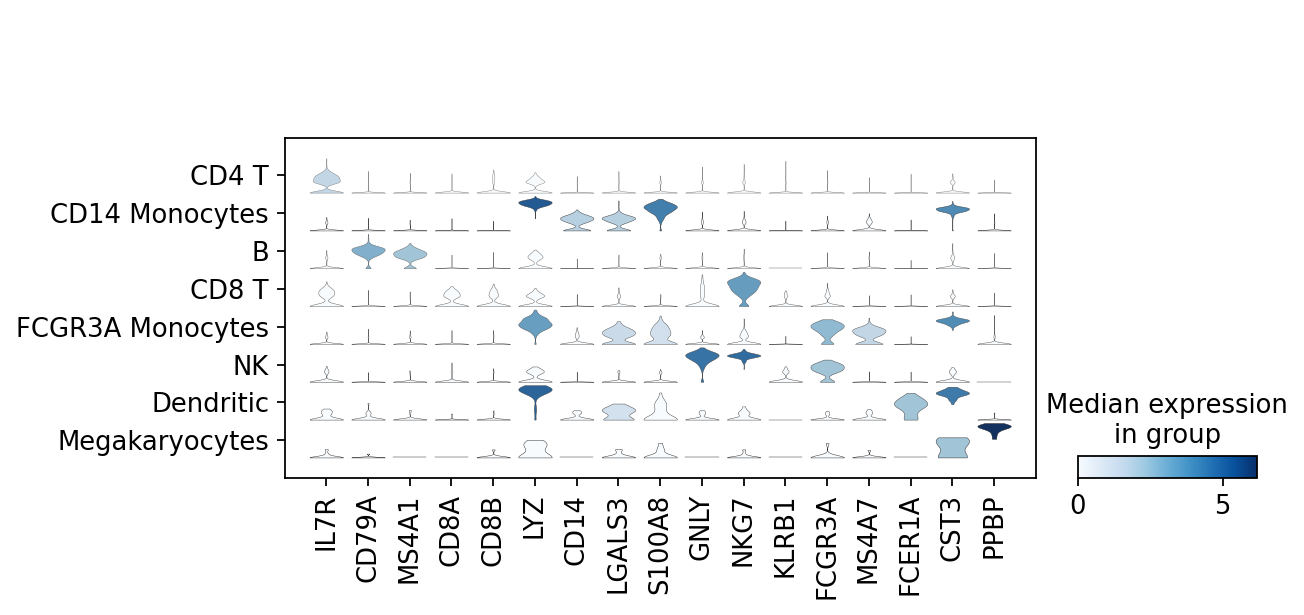

In [73]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [74]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [77]:
# `compression='gzip'` saves disk space, but slows down writing and subsequent reading
adata.write(results_file, compression='gzip')  

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in adata.raw.

In [78]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to “csv”, you have the following options:

In [81]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
    './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
adata.write_csvs(results_file[:-5], )